# DL 모델링

   ## 유통매장 수요량 예측

* 비즈니스 현황
    * 고객사는 A 유통회사의 a 매장 입니다.
    * a 매장에서 주력상품인 a01에 대한 재고 최적화를 위해 수요량을 예측하고자 합니다.
    * 최근 경쟁사의 매장이 가까운 거리에 오픈하였고, 유사한 상품에 대한 공격적인 마케팅을 펼치고 있습니다.
* 발주 최적화를 위한 수요량 예측
    * 일마감 이후, 발주량을 결정할 때, 예측된 수요량이 필요합니다.
    * 발주후 입고까지는 2일의 기간이 걸립니다.
    * 예를 들면
        * 2019년 6월 1일 저녁 10시 일마감 직후, 6월 3일의 수요량을 예측해야 합니다.
        * 예측된 수요량과 현 재고, 안전재고량 등을 감안하여 발주량은 결정되고,
        * 발주 수량은 6월3일 새벽에 매장에 입고되어 6월3일에 판매할 수 있습니다.
* 발주 최적화를 위한 수요량 예측 : 2일후의 판매량을 예측

![](https://www.artefact.com//wp-content/uploads/2021/08/GettyImages-1295864156-scaled.jpg)

# 1.환경준비

## (1) 라이브러리 로딩

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.preprocessing import MinMaxScaler

import scipy.stats as spst
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from keras.backend import clear_session
from keras.models import Sequential
from keras.layers import Dense, LSTM, Conv1D, Flatten
from keras.optimizers import Adam

import joblib

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore')
warnings.simplefilter('ignore', ConvergenceWarning)

## (2) 함수 생성

### 1) 결과 시각화

In [2]:
def plot_model_result(y_train, y_val, pred) :

    y_train = pd.Series(y_train)
    y_val = pd.Series(y_val)
    y_val.index = range(len(y_train), len(y_train) + len(y_val))

    pred = pd.Series(pred, index = y_val.index)

    # 전체 시각화
    plt.figure(figsize = (20,12))
    plt.subplot(2,1,1)
    plt.plot(y_train, label = 'train')
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.subplot(2,1,2)
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.show()

### 2) 잔차분석

In [3]:
def residual_diag(residuals, lags = 30) :
    print('* 정규성 검정(> 0.05) : ', round(spst.shapiro(residuals)[1],5))
    print('* 정상성 검정(< 0.05) : ', round(sm.tsa.stattools.adfuller(residuals)[1],5))
    print('* 자기상관성 확인(ACF, PACF)')
    fig,ax = plt.subplots(1,2, figsize = (15,5))
    plot_acf(residuals, lags = lags, ax = ax[0])
    plot_pacf(residuals, lags = lags, ax = ax[1])
    plt.show()

### 3) 시계열분해 plot

In [4]:
def decomp_plot(decomp) :
    result = pd.DataFrame({'observed':decomp.observed, 'trend':decomp.trend, 'seasonal':decomp.seasonal, 'residual':decomp.resid})
    plt.subplot(4,1,1)
    plt.plot(result['observed'])
    plt.ylabel('observed')
    plt.subplot(4,1,2)
    plt.plot(result['trend'])
    plt.ylabel('trend')
    plt.subplot(4,1,3)
    plt.plot(result['seasonal'])
    plt.ylabel('seasonal')
    plt.subplot(4,1,4)
    plt.plot(result['residual'])
    plt.ylabel('residual')
    plt.show()

    return result

### 4) 2차원 --> 3차원 변환(for LSTM, CNN)

In [5]:
def temporalize(x, y, timestep):
    output_X = []
    output_y = []
    for i in range(len(x) - timestep + 1):
        output_X.append(x.iloc[i:i+timestep])
        output_y.append(y.iloc[i+timestep-1])
    return np.array(output_X), np.array(output_y)

### 5) 스케일링을 위한 함수
* LSTM, CNN를 위한 데이터를 스케일링 하는 것은 조금 까다로움.
* 원본 데이터는 2D, 모델링 하기 위한 데이터셋(X)은 3D.
* 이를 위해 두 함수를 생성합니다.
    * flatten : 3차원을 2차원으로 돌려 놓는 함수
    * scale : 3차원 데이터에 스케일러 적용(transform)

In [6]:
def flatten(X):
    flattened_X = np.empty((X.shape[0], X.shape[2]))
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return flattened_X

def scale(X, scaler):
    for i in range(X.shape[0]):
        X[i, :, :] = scaler.transform(X[i, :, :])
    return X

## (3) 데이터 불러오기

* 32번 파일에서 저장한 데이터를 로딩합니다.

In [7]:
data2 = joblib.load('data_32.pkl')

# 2.전처리1

## (1) 데이터 분할

### 1) x, y 나누기

In [8]:
target = 'y'

x = data2.drop([target, 'date'], axis = 1)
y = data2.loc[:, target]

### 2) 시계열 데이터 분할

In [9]:
val_size = 30
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = val_size, shuffle = False)

## (2) 스케일링

In [10]:
# x
scaler_x = MinMaxScaler()
x_train_s2 = scaler_x.fit_transform(x_train)
x_val_s2 = scaler_x.transform(x_val)

In [11]:
# y에 대한 스케일링(최적화를 위해)
scaler_y = MinMaxScaler()
y_train_s2 = scaler_y.fit_transform(y_train.values.reshape(-1,1))
y_val_s2 = scaler_y.transform(y_val.values.reshape(-1,1))

# 3.모델링1 : DNN

## (1) 학습 및 예측

* 설계

In [17]:
nfeatures = x_train_s2.shape[1]

clear_session()

model1 = Sequential([Dense(64, input_shape = (nfeatures,), activation = 'relu'),
                    Dense(32, activation = 'relu'),
                    Dense(8, activation = 'relu'),
                    Dense(1)])

model1.compile(optimizer= Adam(learning_rate = 0.001) ,loss='mse')

* 학습

In [ ]:
hist = model1.fit(x_train_s2, y_train_s2, epochs=50, validation_split=.2).history

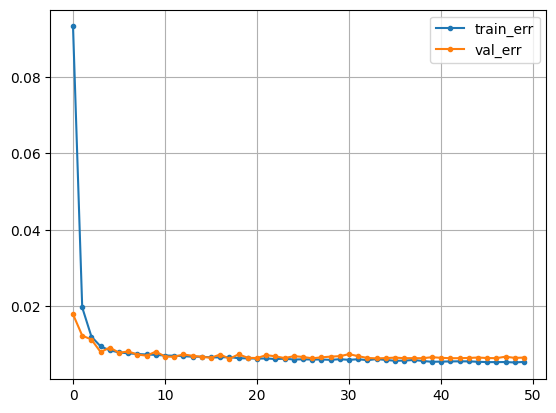

In [19]:
plt.plot(hist['loss'], label = 'train_err', marker = '.')
plt.plot(hist['val_loss'], label = 'val_err', marker = '.')
plt.grid()
plt.legend()
plt.show()

* 예측

In [20]:
pred = model1.predict(x_val_s2)

# 예측 결과를 원래 스케일로 돌려 놓기
pred = scaler_y.inverse_transform(pred)
pred = pred.reshape(-1,)

1/1 [==============================] - 0s 65ms/step


## (2) 평가

### 1) 검증성능

In [21]:
# 평가
print('MAE :', mean_absolute_error(y_val, pred))
print('MAPE:', mean_absolute_percentage_error(y_val, pred))
print('R2  :', r2_score(y_val, pred))

MAE : 9.78473383585612
MAPE: 0.10756217359342492
R2  : 0.2285146239774054


### 2) 결과 시각화

# 4.전처리2

## (1) 3차원 구조로 만들기

In [22]:
x.shape, y.shape

((631, 17), (631,))

In [57]:
timesteps = 14
x2, y2 = temporalize(x, y, timesteps)

In [58]:
x2.shape, y2.shape

((618, 14, 17), (618,))

## (2) 시계열 데이터 분할

In [59]:
val_size = 30
x_train, x_val, y_train, y_val = train_test_split(x2, y2, test_size = val_size, shuffle = False)

# 5.모델링2 : LSTM

## (1) 3차원 데이터셋 전처리 : 스케일링

In [60]:
# 2차원으로 변환하여 스케일러 생성
scaler = MinMaxScaler().fit(flatten(x_train))

# 3차원 데이터에 스테일러 적용
x_train_s3 = scale(x_train, scaler)
x_val_s3 = scale(x_val, scaler)

In [61]:
# y에 대한 스케일링(최적화를 위해)
scaler_y = MinMaxScaler()
y_train_s3 = scaler_y.fit_transform(y_train.reshape(-1,1))
y_val_s3 = scaler_y.transform(y_val.reshape(-1,1))

## (2) 학습 및 예측

* 설계

In [80]:
n_features = x_train_s3.shape[2]

clear_session()

model2 = Sequential([
            LSTM(32, input_shape = (timesteps, n_features), return_sequences = True),
            LSTM(16, return_sequences = True),
            LSTM(8),
            Dense(8, activation = 'relu'),
            Dense(1)
            ])

model2.compile(optimizer = Adam(learning_rate = 0.01), loss='mse')

* 학습

In [81]:
hist = model2.fit(x_train_s3, y_train_s3, epochs=30, validation_split=.2).history

Epoch 1/30
15/15 [==============================] - 9s 218ms/step - loss: 0.0567 - val_loss: 0.0209
Epoch 2/30
15/15 [==============================] - 1s 40ms/step - loss: 0.0207 - val_loss: 0.0167
Epoch 3/30
15/15 [==============================] - 1s 40ms/step - loss: 0.0173 - val_loss: 0.0180
Epoch 4/30
15/15 [==============================] - 1s 38ms/step - loss: 0.0162 - val_loss: 0.0157
Epoch 5/30
15/15 [==============================] - 1s 39ms/step - loss: 0.0180 - val_loss: 0.0145
Epoch 6/30
15/15 [==============================] - 0s 32ms/step - loss: 0.0141 - val_loss: 0.0146
Epoch 7/30
15/15 [==============================] - 0s 26ms/step - loss: 0.0131 - val_loss: 0.0144
Epoch 8/30
15/15 [==============================] - 0s 25ms/step - loss: 0.0118 - val_loss: 0.0130
Epoch 9/30
15/15 [==============================] - 0s 26ms/step - loss: 0.0103 - val_loss: 0.0122
Epoch 10/30
15/15 [==============================] - 0s 29ms/step - loss: 0.0095 - val_loss: 0.0115
Epoch 11

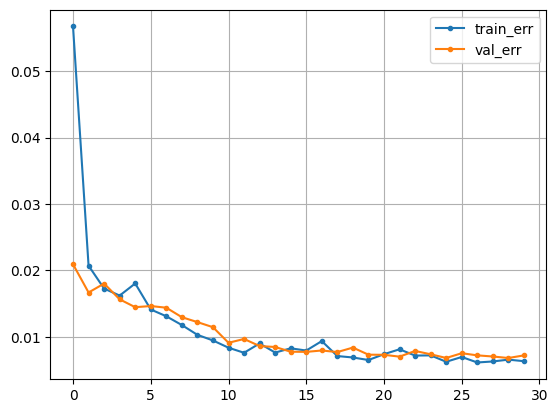

In [82]:
plt.plot(hist['loss'], label = 'train_err', marker = '.')
plt.plot(hist['val_loss'], label = 'val_err', marker = '.')
plt.grid()
plt.legend()
plt.show()

* 예측

In [83]:
pred = model2.predict(x_val_s3)

# 예측 결과를 원래 스케일로 돌려 놓기
pred = scaler_y.inverse_transform(pred)
pred = pred.reshape(-1,)

1/1 [==============================] - 2s 2s/step


## (3) 평가

### 1) 검증성능

In [84]:
# 평가
print('MAE :', mean_absolute_error(y_val, pred))
print('MAPE:', mean_absolute_percentage_error(y_val, pred))
print('R2  :', r2_score(y_val, pred))

MAE : 7.197847493489584
MAPE: 0.0803124363976925
R2  : 0.5978096505852625


### 2) 결과 시각화

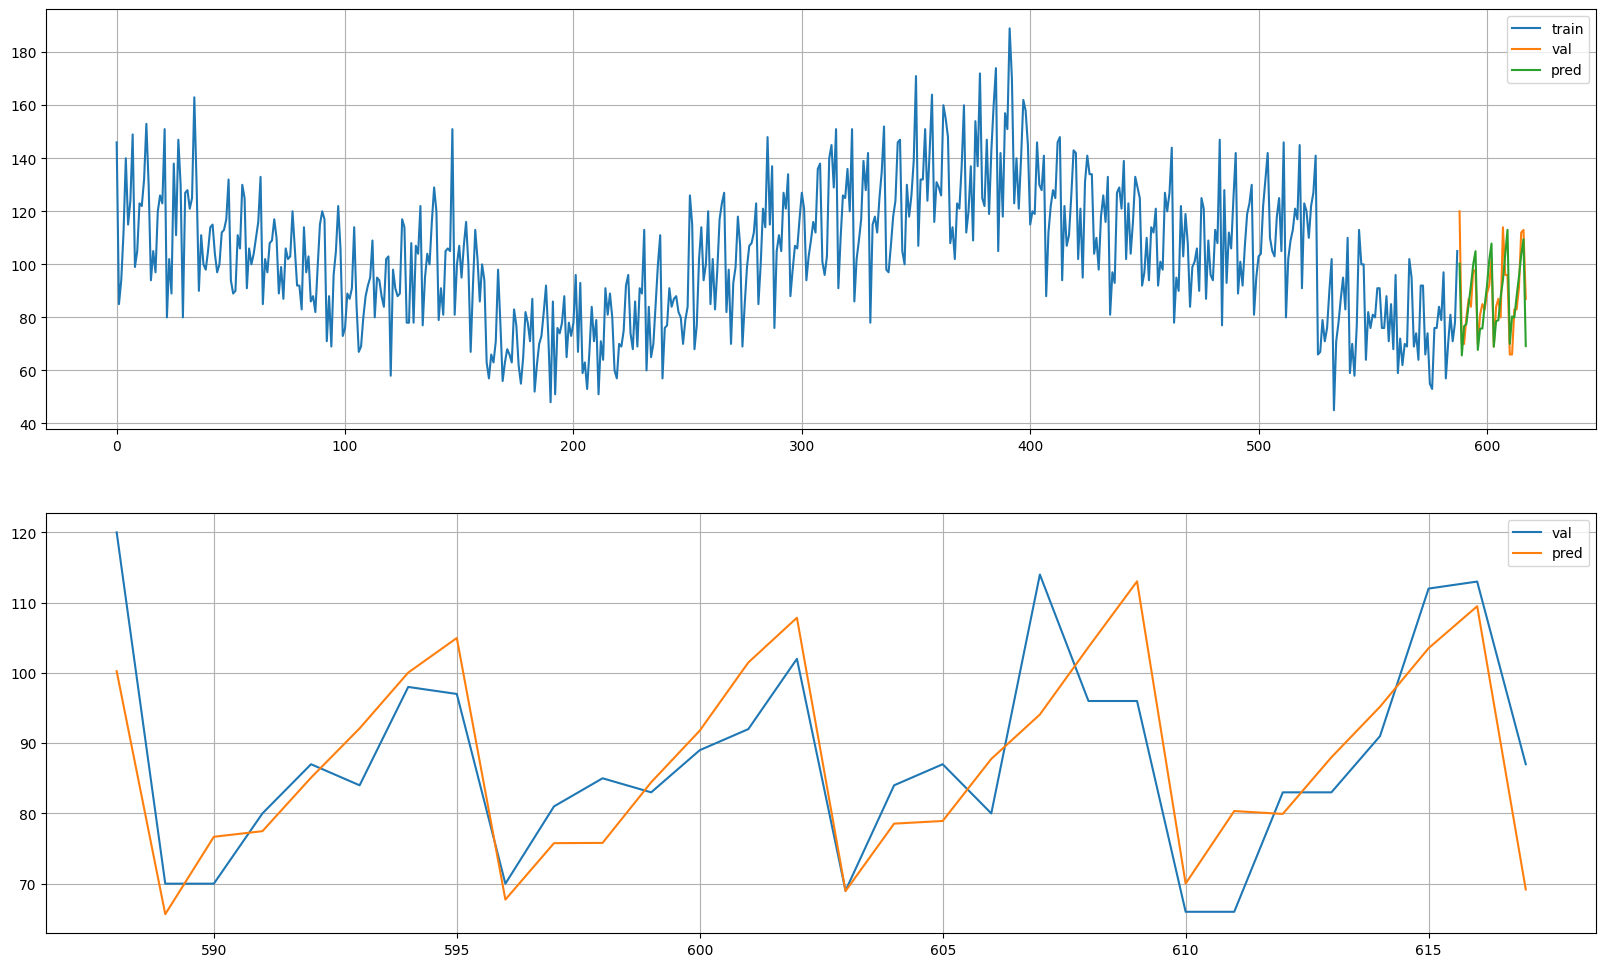

In [85]:
plot_model_result(y_train, y_val, pred)

# 5.모델링2 : LSTM2

## (2) 학습 및 예측

* 설계

In [74]:
n_features = x_train_s3.shape[2]

clear_session()

model3 = Sequential([
            LSTM(32, input_shape = (timesteps, n_features), return_sequences = True),
            LSTM(16, return_sequences = True),
            LSTM(8, return_sequences = True),
            Flatten(),
            Dense(16, activation = 'relu'),
            Dense(8, activation = 'relu'),
            Dense(1)
            ])

model3.compile(optimizer = Adam(learning_rate = 0.001), loss='mse')

* 학습

In [75]:
hist = model3.fit(x_train_s3, y_train_s3, epochs=50, validation_split=.2).history

Epoch 1/50
15/15 [==============================] - 8s 114ms/step - loss: 0.1139 - val_loss: 0.0241
Epoch 2/50
15/15 [==============================] - 0s 24ms/step - loss: 0.0260 - val_loss: 0.0186
Epoch 3/50
15/15 [==============================] - 0s 25ms/step - loss: 0.0187 - val_loss: 0.0162
Epoch 4/50
15/15 [==============================] - 0s 26ms/step - loss: 0.0160 - val_loss: 0.0164
Epoch 5/50
15/15 [==============================] - 0s 24ms/step - loss: 0.0151 - val_loss: 0.0158
Epoch 6/50
15/15 [==============================] - 0s 25ms/step - loss: 0.0144 - val_loss: 0.0162
Epoch 7/50
15/15 [==============================] - 0s 24ms/step - loss: 0.0137 - val_loss: 0.0171
Epoch 8/50
15/15 [==============================] - 0s 26ms/step - loss: 0.0126 - val_loss: 0.0153
Epoch 9/50
15/15 [==============================] - 0s 25ms/step - loss: 0.0115 - val_loss: 0.0143
Epoch 10/50
15/15 [==============================] - 0s 26ms/step - loss: 0.0106 - val_loss: 0.0133
Epoch 11

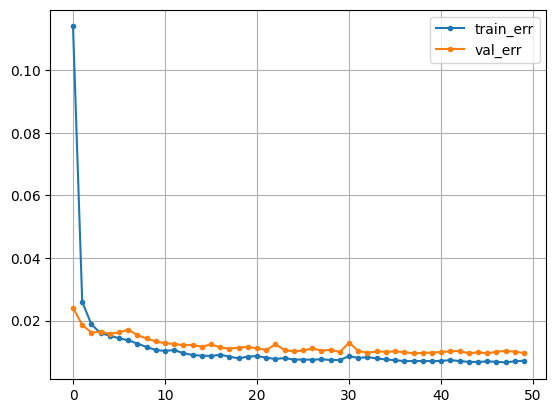

In [76]:
plt.plot(hist['loss'], label = 'train_err', marker = '.')
plt.plot(hist['val_loss'], label = 'val_err', marker = '.')
plt.grid()
plt.legend()
plt.show()

* 예측

In [77]:
pred = model3.predict(x_val_s3)

# 예측 결과를 원래 스케일로 돌려 놓기
pred = scaler_y.inverse_transform(pred)
pred = pred.reshape(-1,)

1/1 [==============================] - 2s 2s/step


## (3) 평가

### 1) 검증성능

In [78]:
# 평가
print('MAE :', mean_absolute_error(y_val, pred))
print('MAPE:', mean_absolute_percentage_error(y_val, pred))
print('R2  :', r2_score(y_val, pred))

MAE : 7.659295781453451
MAPE: 0.08291690526600304
R2  : 0.421164267114403


### 2) 결과 시각화

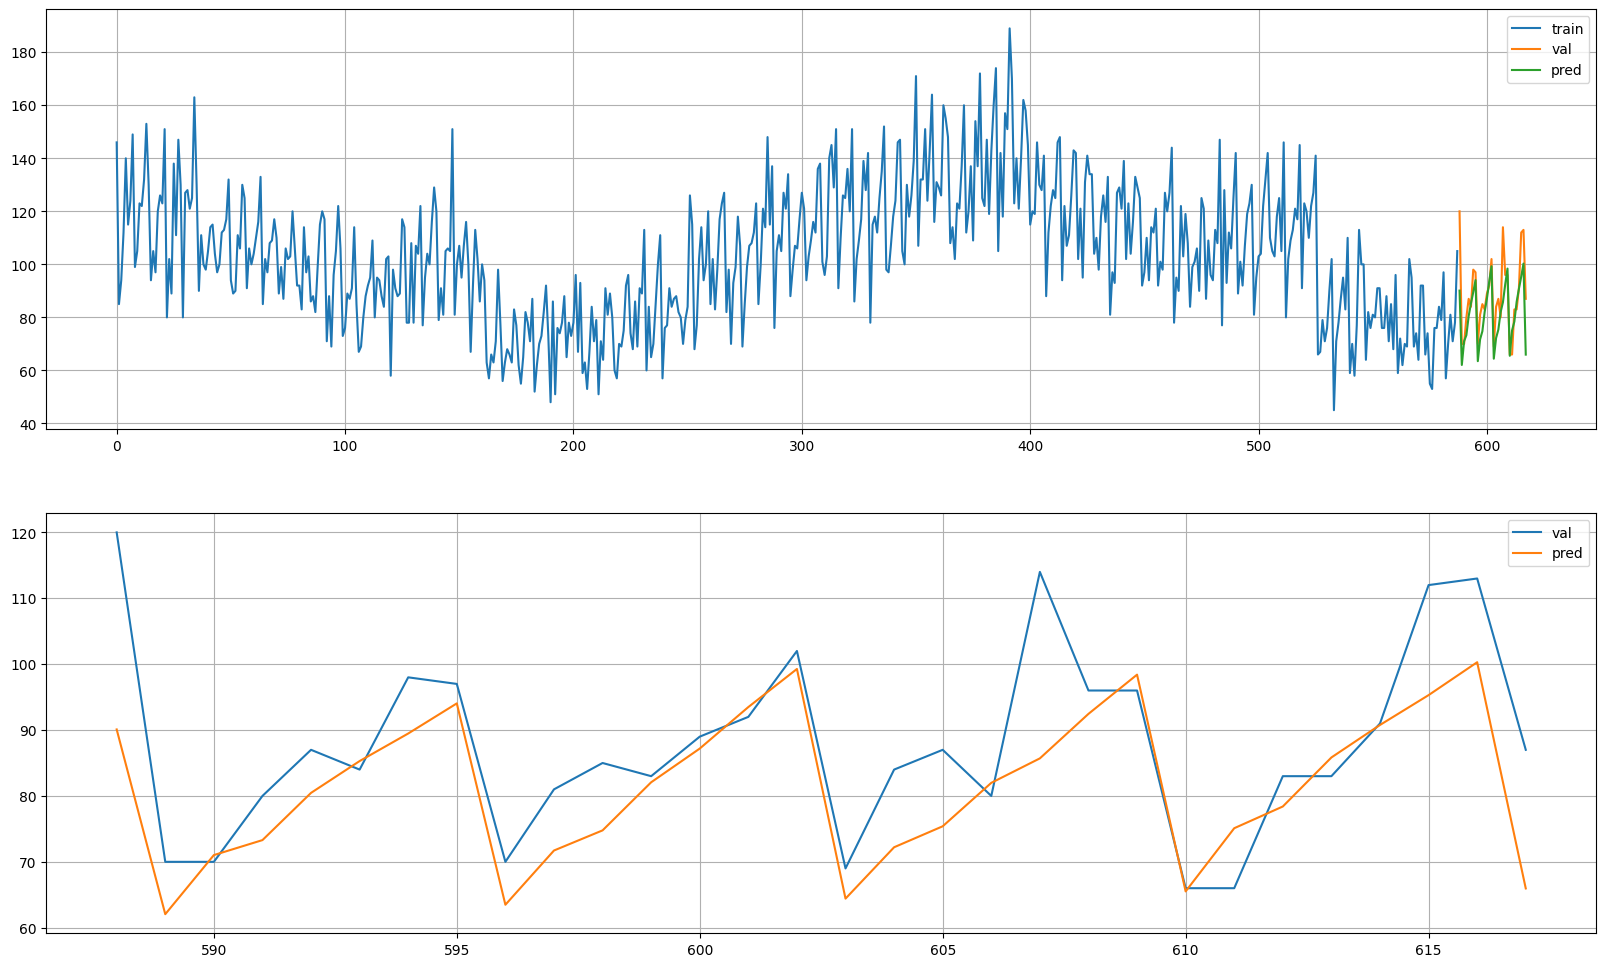

In [79]:
plot_model_result(y_train, y_val, pred)

# 6.모델링3 : CNN

## (1) 학습 및 예측

* 설계

In [107]:
n_features = x_train.shape[2]

clear_session()

model3 = Sequential([
            Conv1D(32, 5, input_shape = (timesteps, n_features), activation='relu', padding = 'same'),
            Conv1D(16, 5, activation='relu', padding = 'same'),
            Conv1D(8, 5, activation='relu', padding = 'same'),
            Flatten(),
            Dense(64, activation = 'relu'),
            Dense(16, activation = 'relu'),
            Dense(1)
            ])

model3.compile(optimizer= Adam(learning_rate = 0.001) ,loss='mse')

* 학습

In [108]:
hist = model3.fit(x_train_s3, y_train_s3, epochs=30, validation_split=.2).history

Epoch 1/30
15/15 [==============================] - 3s 19ms/step - loss: 0.0610 - val_loss: 0.0209
Epoch 2/30
15/15 [==============================] - 0s 7ms/step - loss: 0.0150 - val_loss: 0.0123
Epoch 3/30
15/15 [==============================] - 0s 8ms/step - loss: 0.0099 - val_loss: 0.0097
Epoch 4/30
15/15 [==============================] - 0s 13ms/step - loss: 0.0086 - val_loss: 0.0088
Epoch 5/30
15/15 [==============================] - 0s 14ms/step - loss: 0.0076 - val_loss: 0.0091
Epoch 6/30
15/15 [==============================] - 0s 11ms/step - loss: 0.0073 - val_loss: 0.0088
Epoch 7/30
15/15 [==============================] - 0s 10ms/step - loss: 0.0069 - val_loss: 0.0098
Epoch 8/30
15/15 [==============================] - 0s 12ms/step - loss: 0.0068 - val_loss: 0.0093
Epoch 9/30
15/15 [==============================] - 0s 11ms/step - loss: 0.0066 - val_loss: 0.0093
Epoch 10/30
15/15 [==============================] - 0s 12ms/step - loss: 0.0064 - val_loss: 0.0087
Epoch 11/30

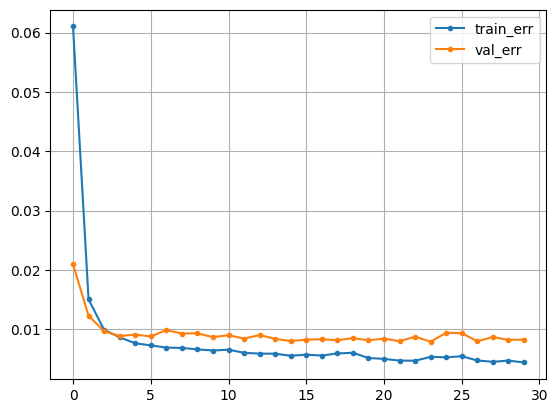

In [109]:
plt.plot(hist['loss'], label = 'train_err', marker = '.')
plt.plot(hist['val_loss'], label = 'val_err', marker = '.')
plt.grid()
plt.legend()
plt.show()

* 예측

In [110]:
pred = model3.predict(x_val_s3)

# 예측 결과를 원래 스케일로 돌려 놓기
pred = scaler_y.inverse_transform(pred)
pred = pred.reshape(-1,)

1/1 [==============================] - 0s 102ms/step


## (2) 평가

### 1) 검증성능

In [111]:
# 평가
print('MAE :', mean_absolute_error(y_val, pred))
print('MAPE:', mean_absolute_percentage_error(y_val, pred))
print('R2  :', r2_score(y_val, pred))

MAE : 8.680408223470051
MAPE: 0.09532115536343315
R2  : 0.3564914021219927


### 2) 결과 시각화

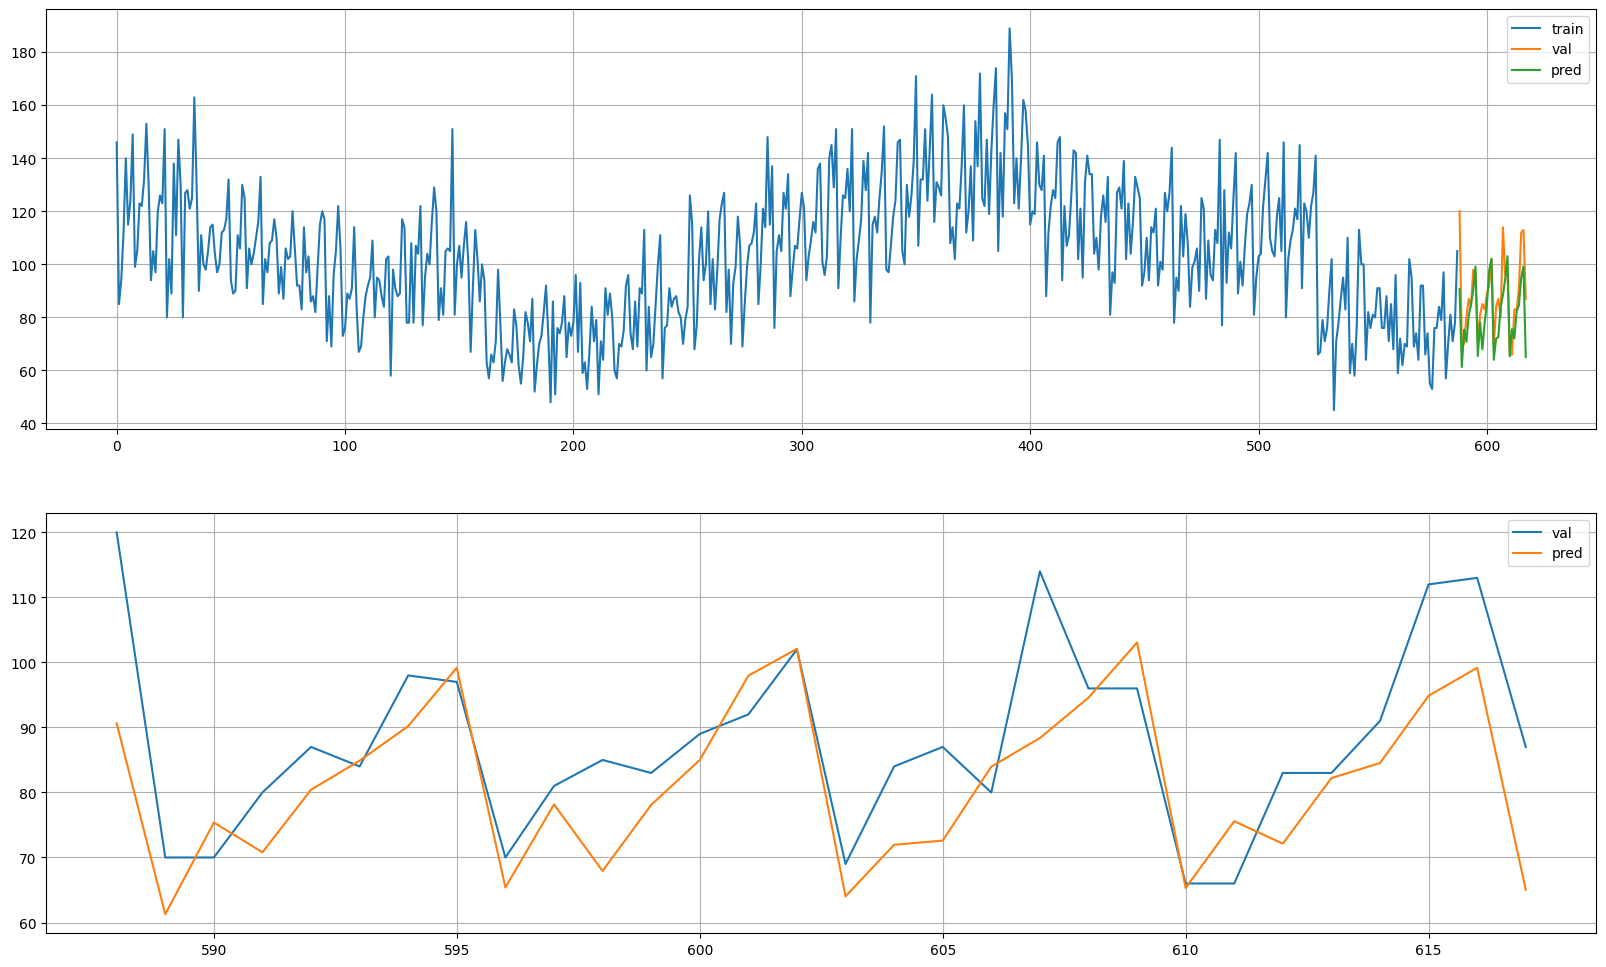

In [112]:
plot_model_result(y_train, y_val, pred)

# 7.예측결과 저장
* joblib을 이용하여
* 가장 성능이 좋았던 모델의 예측 결과를 저장합니다.


In [113]:
import joblib

joblib.dump( pred, 'pred_42.pkl')

['pred_42.pkl']

**저장된 파일을 다운로드 받으세요.**
* 왼쪽 파일 탭 > 저장한 파일 오른쪽 클릭 > 다운로드